In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Installing lightning as :
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

import lightning as L
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
print(L.__version__)

2.3.0dev


## Building the Neural Network

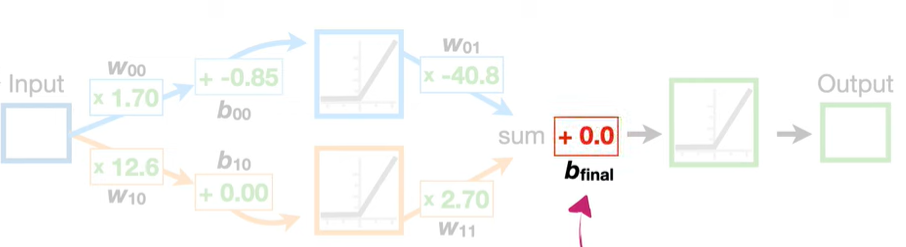

In [8]:
class BasicLightning(L.LightningModule): # inherit from LightningModule instead of nn.Module
  def __init__(self):
    super().__init__() # call the initialization method for the parent class, Lightning Module

    self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad = False)
    self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad = False)
    self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad = False)

    self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad = False)
    self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad = False)
    self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad = False)

    self.final_bias = nn.Parameter(torch.tensor(-16.), requires_grad = False)

  def forward(self, input):
    input_to_top_relu  = input*self.w00 + self.b00
    top_relu_output = F.relu(input_to_top_relu)
    scaled_top_relu_output = top_relu_output * self.w01

    input_to_bottom_relu  = input*self.w10 + self.b10
    bottom_relu_output = F.relu(input_to_bottom_relu)
    scaled_bottom_relu_output = bottom_relu_output * self.w11

    input_to_final_relu = (scaled_top_relu_output
                           + scaled_bottom_relu_output
                           +self.final_bias)
    output = F.relu(input_to_final_relu)
    return output










In [6]:
# Testing
input_doses = torch.linspace(start = 0, end = 1, steps = 11)
input_doses

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

In [9]:
model = BasicLightning()
output_values = model(input_doses)

Text(0.5, 0, 'Dose')

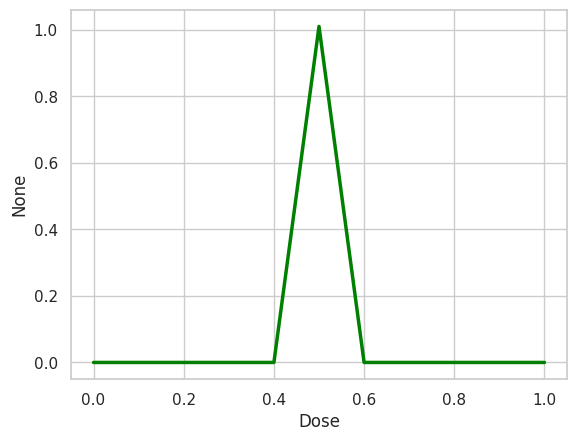

In [12]:
sns.set(style = 'whitegrid')

sns.lineplot(x = input_doses,
             y = output_values,
             color = 'green',
             linewidth = 2.5)
plt.xlabel('Effectiveness')
plt.xlabel('Dose')

We see how Lightning makes  easier to train a model. We will set b_final to 0

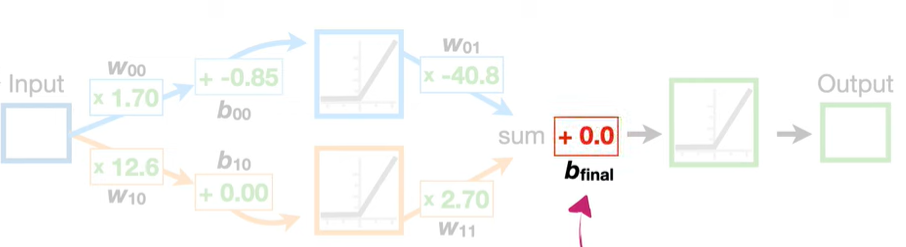

In [42]:
# Make a copy and change the name
class BasicLightningTrain(L.LightningModule): # inherit from LightningModule instead of nn.Module
  def __init__(self):
    super().__init__() # call the initialization method for the parent class, Lightning Module

    self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad = False)
    self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad = False)
    self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad = False)

    self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad = False)
    self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad = False)
    self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad = False)

    self.final_bias = nn.Parameter(torch.tensor(0.0), requires_grad = True)  # <== change is here

    self.learning_rate = 0.01

  def forward(self, input):
    input_to_top_relu  = input*self.w00 + self.b00
    top_relu_output = F.relu(input_to_top_relu)
    scaled_top_relu_output = top_relu_output * self.w01

    input_to_bottom_relu  = input*self.w10 + self.b10
    bottom_relu_output = F.relu(input_to_bottom_relu)
    scaled_bottom_relu_output = bottom_relu_output * self.w11

    input_to_final_relu = (scaled_top_relu_output
                            + scaled_bottom_relu_output
                            +self.final_bias)
    output = F.relu(input_to_final_relu)
    return output

  def configure_optimizers(self):
    return SGD(self.parameters(), lr = self.learning_rate)

  def training_step(self, batch, batch_idx): # batch of training data nad index for that batch

    input_i , label_i =batch
    output_i = self.forward(input_i)
    loss = (output_i - label_i)**2
    self.log('train_loss', loss)  # Logging the training loss

    return loss



Text(0.5, 0, 'Dose')

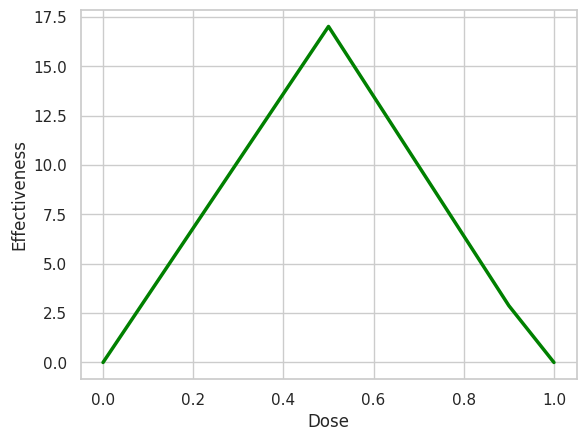

In [18]:
model = BasicLightningTrain()
output_values = model(input_doses)
sns.set(style = 'whitegrid')

sns.lineplot(x = input_doses,
             y = output_values.detach(),
             color = 'green',
             linewidth = 2.5)

plt.ylabel('Effectiveness')
plt.xlabel('Dose')


This graph is showing that effectiveness = 17 when dose = 0.5 which is way too highand that means we need to optimize b_final  . We need to create training data by creating a tensor called inputs with three input doses : 0, 0.5 and 1  . Another tensor called labels that has the known values 0, 1 and 0 .

In [43]:
inputs = torch.tensor([0., 0.5, 1.])
labels = torch.tensor([0., 1., 0.])

# wrap the training data into the DataLoader

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)



In [44]:
model2 = BasicLightningTrain()
trainer = L.Trainer(max_epochs = 34)

#create the Tuner
tuner = L.pytorch.tuner.Tuner(trainer) # lighning version 2.0.0

#Tune the leanring rate
lr_find_results = tuner.lr_find(model2,
                                train_dataloaders = dataloader,
                                min_lr = 0.001,
                                max_lr = 0.1,
                                early_stop_threshold = None)
new_lr = lr_find_results.suggestion()

print(f"lr_find() suggests {new_lr: .5f} for the learning rate")

model2.learning_rate = new_lr






INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0016595869074375606
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0016595869074375606
INFO: Restoring states from the checkpoint path at /content/.lr_find_946ff06c-48be-4a45-9d24-475f37ca203b.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_946ff06c-48be-4a45-9d24-475f37ca203b.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_946ff06c-48be-4a45-9d24-475f37ca203b.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_946ff06c-48be-4a45-9d24-475f37ca203b.ckpt


lr_find() suggests  0.00166 for the learning rate


Let's train the model . In the training step without us having to do anything , the Trainer will call : optimizer.zero_grad() , so that each epoch starts with a fresh gradient . then loss.backward() to calculate then new gradient and then optimizer.step() to take a step towards optimal values for the paramaeters .

In [45]:
trainer.fit(model2, train_dataloaders = dataloader)
print(model2.final_bias.data)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type | Params
--------------------------------------
  | other params | n/a  | 7     
--------------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type | Params
--------------------------------------
  | other params | n/a  | 7     
--------------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=34` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=34` reached.


tensor(-1.7112)


Let's plot it.

Text(0, 0.5, 'Dose')

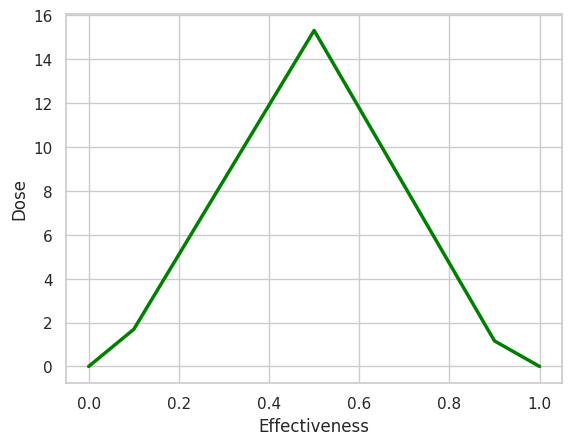

In [46]:
output_values = model2(input_doses)

sns.set(style = 'whitegrid')
sns.lineplot(x = input_doses,
             y = output_values.detach(),
             color = 'green',
             linewidth = 2.5)
plt.xlabel('Effectiveness')
plt.ylabel('Dose')


     trainer = L.Trainer(max_epochs = 34, accelerator = 'auto', devices = 'auto')
accelerator = 'auto' means automatically detect that gpus are there or not .

devices = 'auto' determine how many GPUs are avilable by setting devices to auto .